<a href="https://colab.research.google.com/github/sajjad-shirazy/python-notebooks/blob/master/celebA_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import zipfile

zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/ML/img_align_celeba.zip", 'r')
zip_ref.extractall("/data/img_align_celeba/")
zip_ref.close()

In [0]:
!ls /data/img_align_celeba/img_align_celeba/ -U | head -4

108040.jpg
062198.jpg
190663.jpg
165207.jpg


In [0]:
## load modules
import matplotlib.pyplot as plt
import os, time  
import numpy as np 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.95
# config.gpu_options.visible_device_list = "1" 
# set_session(tf.Session(config=config))

Using TensorFlow backend.


In [0]:
dir_data      = "/data/img_align_celeba/img_align_celeba"
Ntrain        = 100 
Ntest         = 100
nm_imgs       = np.sort(os.listdir(dir_data))
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]
## name of the jpg files for the testing data
nm_imgs_test  = nm_imgs[Ntrain:Ntrain + Ntest]
img_shape     = (32, 32, 3)

def get_npdata(nm_imgs_train):
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
        image = load_img(dir_data + "/" + myid,
                         target_size=img_shape[:2])
        image = img_to_array(image)/255.0
        X_train.append(image)
    X_train = np.array(X_train)
    return(X_train)

X_train = get_npdata(nm_imgs_train)
print("X_train.shape = {}".format(X_train.shape))

X_test  = get_npdata(nm_imgs_test)
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (100, 32, 32, 3)
X_test.shape = (100, 32, 32, 3)


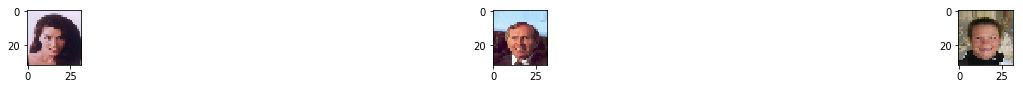

In [0]:
fig = plt.figure(figsize=(32,1))
nplot = 4
for count in range(1,nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(X_train[count*10])
plt.show()

In [0]:
import numpy as np
from keras import layers, models
from keras.optimizers import Adam

## optimizer
#optimizer = Adam(0.0002, 0.5)
optimizer = Adam(0.00007, 0.5)

def build_generator(img_shape, noise_shape = (100,)):
    '''
    noise_shape : the dimension of the input vector for the generator
    img_shape   : the dimension of the output
    '''
    ## latent variable as input
    input_noise = layers.Input(shape=noise_shape) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(128*8*8, activation="relu")(d)
    d = layers.Reshape((8,8,128))(d)
    
    d = layers.Conv2DTranspose(128, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_4")(d) ## 16,16


    d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_5")(d) ## 32,32
    
    if img_shape[0] == 64:
        d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
        d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_6")(d) ## 64,64
    
    img = layers.Conv2D( 3 , ( 1 , 1 ) , activation='sigmoid' , padding='same', name="final_block")(d) ## 32, 32
    model = models.Model(input_noise, img)
    model.summary() 
    return(model)

## Set the dimension of latent variables to be 100
noise_shape = (100,)

generator = build_generator(img_shape, noise_shape = noise_shape)

generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       65536     
_________________________________________________________________
block_4 (Conv2D)             (None, 16, 16, 64)        8256      
_________________________________________________________________
conv

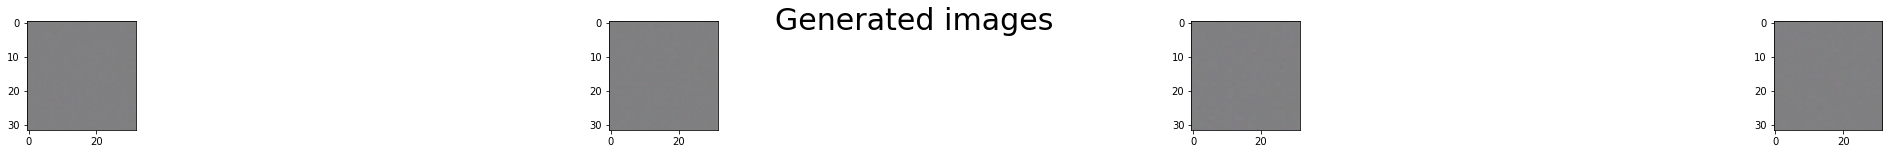

In [0]:
def get_noise(nsample=1, nlatent_dim=100):
    noise = np.random.normal(0, 1, (nsample,nlatent_dim))
    return(noise)

def plot_generated_images(noise,path_save=None,titleadd=""):
    imgs = generator.predict(noise)
    fig = plt.figure(figsize=(40,2))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,nsample,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()

nsample = 4
noise = get_noise(nsample=nsample, nlatent_dim=noise_shape[0])
plot_generated_images(noise)

In [0]:
def build_discriminator(img_shape,noutput=1):
    input_img = layers.Input(shape=img_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_img)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), name='block4_pool')(x)

    
    x         = layers.Flatten()(x)
    x         = layers.Dense(1024,      activation="relu")(x)
    out       = layers.Dense(noutput,   activation='sigmoid')(x)
    model     = models.Model(input_img, out)
    
    return model

discriminator  = build_discriminator(img_shape)
discriminator.compile(loss      = 'binary_crossentropy', 
                      optimizer = optimizer,
                      metrics   = ['accuracy'])

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 32)        9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 64)          0         
__________

In [0]:
z = layers.Input(shape=noise_shape)
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = models.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         8584515   
_________________________________________________________________
model_2 (Model)              (None, 1)                 6711585   
Total params: 15,296,100
Trainable params: 8,584,515
Non-trainable params: 6,711,585
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 00000 [D loss: 0.722, acc.: 043.4%] [G loss: 0.654]


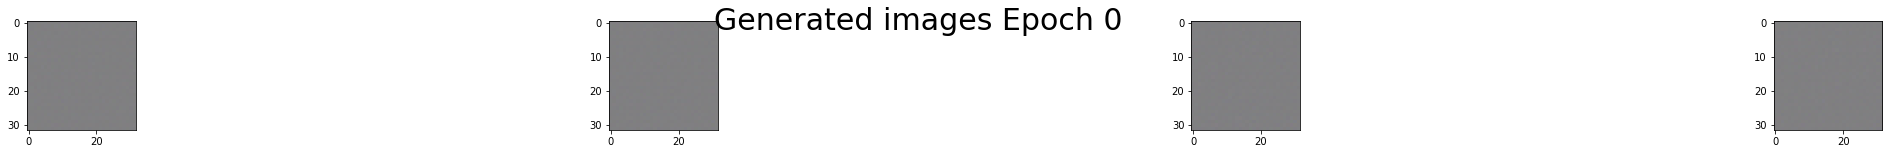

Epoch 00001 [D loss: 0.693, acc.: 050.0%] [G loss: 0.649]
Epoch 00002 [D loss: 0.684, acc.: 050.0%] [G loss: 0.647]
Epoch 00003 [D loss: 0.676, acc.: 050.0%] [G loss: 0.645]
Epoch 00004 [D loss: 0.666, acc.: 050.0%] [G loss: 0.643]
Epoch 00005 [D loss: 0.656, acc.: 050.0%] [G loss: 0.643]
Epoch 00006 [D loss: 0.642, acc.: 050.0%] [G loss: 0.643]
Epoch 00007 [D loss: 0.624, acc.: 050.0%] [G loss: 0.648]
Epoch 00008 [D loss: 0.600, acc.: 050.0%] [G loss: 0.653]
Epoch 00009 [D loss: 0.573, acc.: 050.0%] [G loss: 0.666]
Epoch 00010 [D loss: 0.533, acc.: 050.0%] [G loss: 0.684]


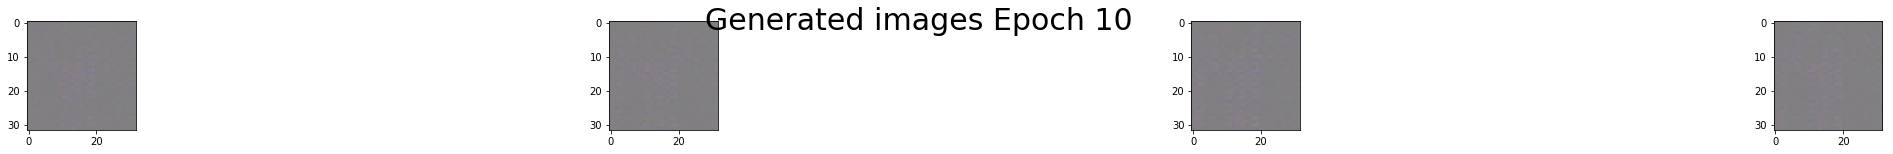

Epoch 00011 [D loss: 0.502, acc.: 050.0%] [G loss: 0.712]
Epoch 00012 [D loss: 0.451, acc.: 052.7%] [G loss: 0.746]
Epoch 00013 [D loss: 0.411, acc.: 100.0%] [G loss: 0.790]
Epoch 00014 [D loss: 0.363, acc.: 100.0%] [G loss: 0.843]
Epoch 00015 [D loss: 0.326, acc.: 100.0%] [G loss: 0.914]
Epoch 00016 [D loss: 0.280, acc.: 100.0%] [G loss: 1.008]
Epoch 00017 [D loss: 0.246, acc.: 100.0%] [G loss: 1.133]
Epoch 00018 [D loss: 0.211, acc.: 100.0%] [G loss: 1.290]
Epoch 00019 [D loss: 0.166, acc.: 100.0%] [G loss: 1.513]
Epoch 00020 [D loss: 0.122, acc.: 100.0%] [G loss: 1.808]


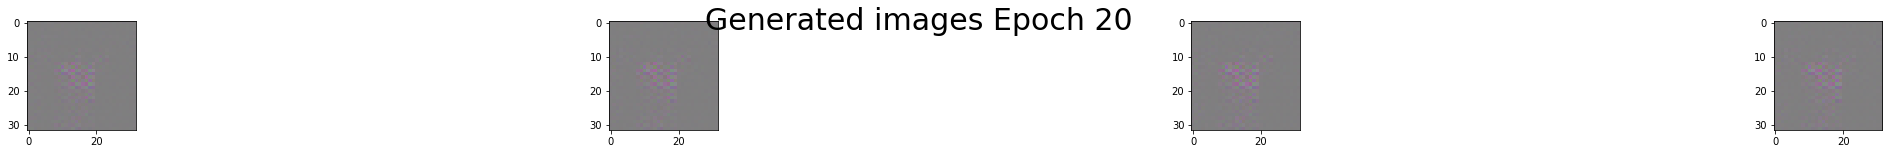

Epoch 00021 [D loss: 0.101, acc.: 100.0%] [G loss: 2.107]
Epoch 00022 [D loss: 0.063, acc.: 100.0%] [G loss: 2.459]
Epoch 00023 [D loss: 0.047, acc.: 100.0%] [G loss: 2.860]
Epoch 00024 [D loss: 0.044, acc.: 099.7%] [G loss: 3.079]
Epoch 00025 [D loss: 0.023, acc.: 100.0%] [G loss: 3.376]
Epoch 00026 [D loss: 0.016, acc.: 100.0%] [G loss: 3.702]
Epoch 00027 [D loss: 0.012, acc.: 100.0%] [G loss: 3.990]
Epoch 00028 [D loss: 0.010, acc.: 100.0%] [G loss: 4.239]
Epoch 00029 [D loss: 0.008, acc.: 100.0%] [G loss: 4.440]
Epoch 00030 [D loss: 0.011, acc.: 100.0%] [G loss: 4.610]


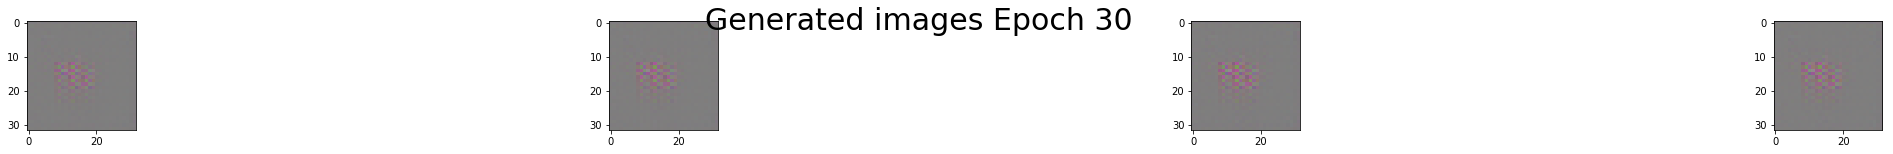

Epoch 00031 [D loss: 0.011, acc.: 100.0%] [G loss: 4.688]
Epoch 00032 [D loss: 0.021, acc.: 100.0%] [G loss: 4.978]
Epoch 00033 [D loss: 0.298, acc.: 087.3%] [G loss: 5.469]
Epoch 00034 [D loss: 1.580, acc.: 061.3%] [G loss: 2.033]
Epoch 00035 [D loss: 0.840, acc.: 052.2%] [G loss: 2.822]
Epoch 00036 [D loss: 0.090, acc.: 097.0%] [G loss: 2.995]
Epoch 00037 [D loss: 0.451, acc.: 083.1%] [G loss: 2.600]
Epoch 00038 [D loss: 0.183, acc.: 094.5%] [G loss: 2.414]
Epoch 00039 [D loss: 0.096, acc.: 097.3%] [G loss: 2.320]
Epoch 00040 [D loss: 0.083, acc.: 099.3%] [G loss: 2.272]


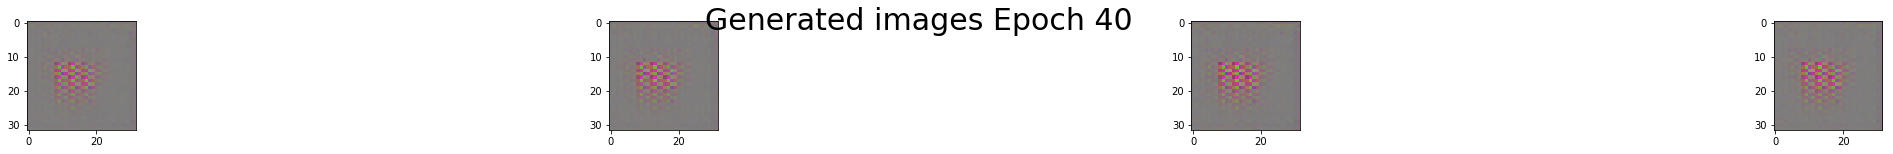

Epoch 00041 [D loss: 0.109, acc.: 098.2%] [G loss: 2.296]
Epoch 00042 [D loss: 0.124, acc.: 098.6%] [G loss: 2.443]
Epoch 00043 [D loss: 0.184, acc.: 094.9%] [G loss: 2.554]
Epoch 00044 [D loss: 0.286, acc.: 089.8%] [G loss: 2.734]
Epoch 00045 [D loss: 0.377, acc.: 089.4%] [G loss: 2.781]
Epoch 00046 [D loss: 0.518, acc.: 079.1%] [G loss: 2.912]
Epoch 00047 [D loss: 0.517, acc.: 082.2%] [G loss: 2.633]
Epoch 00048 [D loss: 0.558, acc.: 077.3%] [G loss: 2.876]
Epoch 00049 [D loss: 0.431, acc.: 086.6%] [G loss: 2.410]
Epoch 00050 [D loss: 0.423, acc.: 082.0%] [G loss: 2.760]


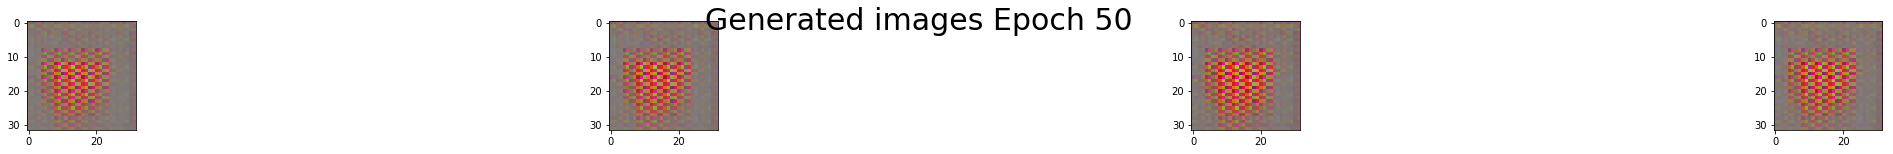

Epoch 00051 [D loss: 0.302, acc.: 090.2%] [G loss: 2.561]
Epoch 00052 [D loss: 0.214, acc.: 093.8%] [G loss: 2.256]
Epoch 00053 [D loss: 0.198, acc.: 094.1%] [G loss: 2.616]
Epoch 00054 [D loss: 0.153, acc.: 095.5%] [G loss: 2.592]
Epoch 00055 [D loss: 0.171, acc.: 095.3%] [G loss: 2.520]
Epoch 00056 [D loss: 0.155, acc.: 095.2%] [G loss: 2.702]
Epoch 00057 [D loss: 0.135, acc.: 095.0%] [G loss: 2.645]
Epoch 00058 [D loss: 0.121, acc.: 096.4%] [G loss: 2.768]
Epoch 00059 [D loss: 0.138, acc.: 095.4%] [G loss: 2.803]
Epoch 00060 [D loss: 0.199, acc.: 093.2%] [G loss: 2.876]


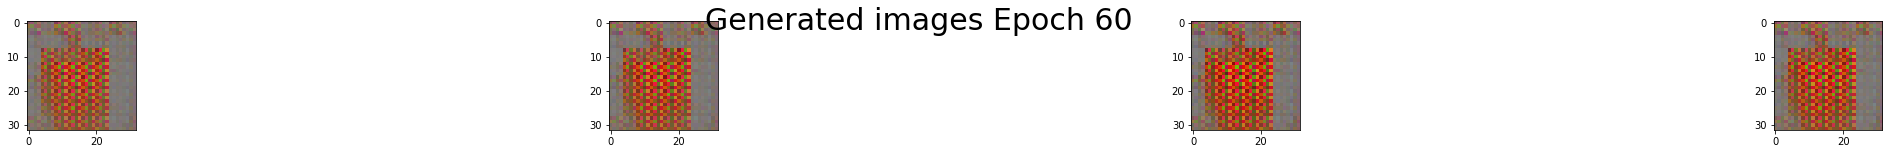

Epoch 00061 [D loss: 0.144, acc.: 094.3%] [G loss: 2.712]
Epoch 00062 [D loss: 0.140, acc.: 096.7%] [G loss: 2.877]
Epoch 00063 [D loss: 0.134, acc.: 095.5%] [G loss: 2.747]
Epoch 00064 [D loss: 0.163, acc.: 097.0%] [G loss: 2.960]
Epoch 00065 [D loss: 0.154, acc.: 094.0%] [G loss: 2.750]
Epoch 00066 [D loss: 0.240, acc.: 093.1%] [G loss: 3.133]
Epoch 00067 [D loss: 0.215, acc.: 091.4%] [G loss: 2.596]
Epoch 00068 [D loss: 0.259, acc.: 094.3%] [G loss: 3.006]
Epoch 00069 [D loss: 0.204, acc.: 091.2%] [G loss: 2.591]
Epoch 00070 [D loss: 0.222, acc.: 096.0%] [G loss: 2.662]


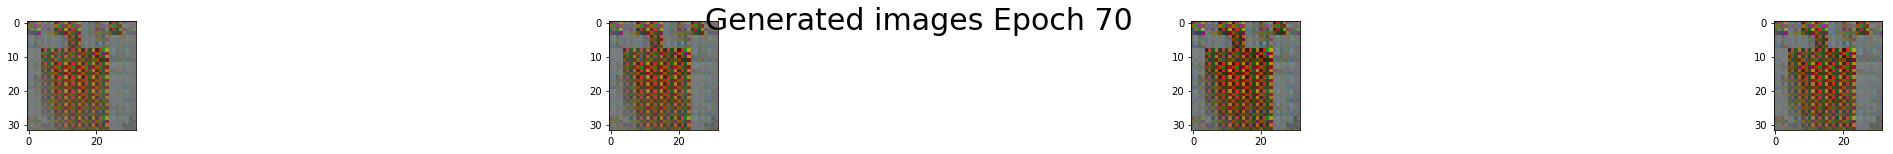

Epoch 00071 [D loss: 0.213, acc.: 093.2%] [G loss: 2.533]
Epoch 00072 [D loss: 0.319, acc.: 091.5%] [G loss: 2.704]
Epoch 00073 [D loss: 0.440, acc.: 086.2%] [G loss: 2.157]
Epoch 00074 [D loss: 0.374, acc.: 091.0%] [G loss: 2.359]
Epoch 00075 [D loss: 0.422, acc.: 086.0%] [G loss: 1.883]
Epoch 00076 [D loss: 0.395, acc.: 090.5%] [G loss: 2.023]
Epoch 00077 [D loss: 0.378, acc.: 088.2%] [G loss: 1.809]
Epoch 00078 [D loss: 0.366, acc.: 089.0%] [G loss: 1.872]
Epoch 00079 [D loss: 0.281, acc.: 091.5%] [G loss: 1.922]
Epoch 00080 [D loss: 0.257, acc.: 093.2%] [G loss: 1.931]


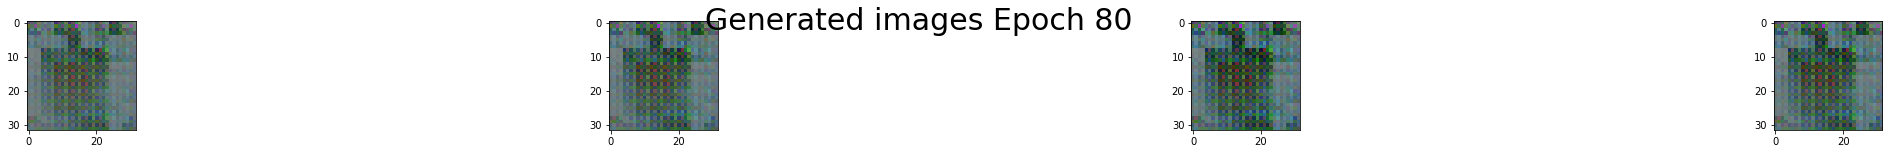

Epoch 00081 [D loss: 0.195, acc.: 093.9%] [G loss: 2.053]
Epoch 00082 [D loss: 0.191, acc.: 094.3%] [G loss: 2.084]
Epoch 00083 [D loss: 0.171, acc.: 096.0%] [G loss: 2.223]
Epoch 00084 [D loss: 0.120, acc.: 097.1%] [G loss: 2.330]
Epoch 00085 [D loss: 0.108, acc.: 098.6%] [G loss: 2.385]
Epoch 00086 [D loss: 0.109, acc.: 098.5%] [G loss: 2.456]
Epoch 00087 [D loss: 0.109, acc.: 098.8%] [G loss: 2.577]
Epoch 00088 [D loss: 0.136, acc.: 096.7%] [G loss: 2.565]
Epoch 00089 [D loss: 0.211, acc.: 094.0%] [G loss: 2.713]
Epoch 00090 [D loss: 0.243, acc.: 092.8%] [G loss: 2.660]


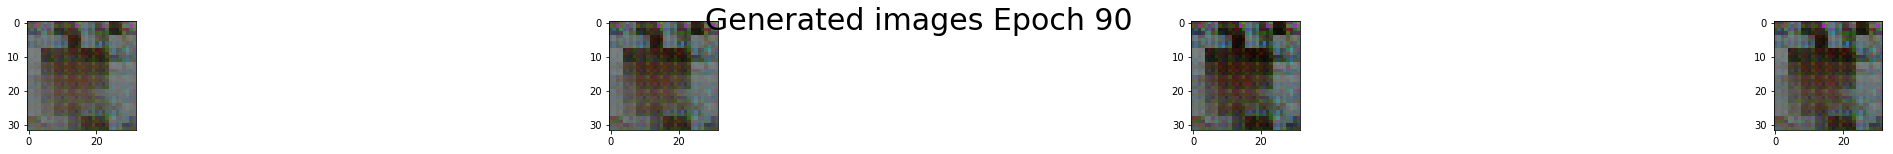

Epoch 00091 [D loss: 0.260, acc.: 092.5%] [G loss: 2.805]
Epoch 00092 [D loss: 0.568, acc.: 068.8%] [G loss: 2.964]
Epoch 00093 [D loss: 0.664, acc.: 083.2%] [G loss: 1.993]
Epoch 00094 [D loss: 0.354, acc.: 093.3%] [G loss: 2.681]
Epoch 00095 [D loss: 0.662, acc.: 081.5%] [G loss: 1.897]
Epoch 00096 [D loss: 0.364, acc.: 092.6%] [G loss: 2.348]
Epoch 00097 [D loss: 0.325, acc.: 089.8%] [G loss: 2.008]
Epoch 00098 [D loss: 0.270, acc.: 095.2%] [G loss: 2.163]
Epoch 00099 [D loss: 0.215, acc.: 094.3%] [G loss: 2.181]
----------
Time took: 1.47 min


In [0]:
def train(models, X_train, noise_plot, dir_result="/result/", epochs=10000, batch_size=128):
        '''
        models     : tuple containins three tensors, (combined, discriminator, generator)
        X_train    : np.array containing images (Nsample, height, width, Nchannels)
        noise_plot : np.array of size (Nrandom_sample_to_plot, hidden unit length)
        dir_result : the location where the generated plots for noise_plot are saved 
        
        '''
        combined, discriminator, generator = models
        nlatent_dim = noise_plot.shape[1]
        half_batch  = int(batch_size / 2)
        history = []
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            noise = get_noise(half_batch, nlatent_dim)

            # Generate a half batch of new images
            gen_imgs = generator.predict(noise)

            
            # Train the discriminator q: better to mix them together?
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = get_noise(batch_size, nlatent_dim)

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = (np.array([1] * batch_size)).reshape(batch_size,1)
            
            # Train the generator
            g_loss = combined.train_on_batch(noise, valid_y)

            history.append({"D":d_loss[0],"G":g_loss})
            
#             if epoch % 10 == 1:
            # Plot the progress
            print ("Epoch {:05.0f} [D loss: {:4.3f}, acc.: {:05.1f}%] [G loss: {:4.3f}]".format(
                epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % int(epochs/100) == 0:
                plot_generated_images(noise_plot,
                                      path_save=dir_result+"/image_{:05.0f}.png".format(epoch),
                                      titleadd="Epoch {}".format(epoch))
            if epoch % 10 == 0:
                plot_generated_images(noise_plot,
                                      titleadd="Epoch {}".format(epoch))
                        
        return(history)

dir_result="./result_GAN/"

try:
    os.mkdir(dir_result)
except:
    pass
    
start_time = time.time()

_models = combined, discriminator, generator          

history = train(_models, X_train, noise, dir_result=dir_result,epochs=100, batch_size=128*8)
end_time = time.time()
print("-"*10)
print("Time took: {:4.2f} min".format((end_time - start_time)/60))